# Simulation de l'algorithme des colonies d'abeilles

## 1 - Fonctions nécessaires

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib

plt.rcParams["axes.autolimit_mode"] = "round_numbers"


def schwefel(*x):
    d = len(x)

    res = 0 * x[0]

    for xi in x:
        res += xi * np.sin(np.sqrt(np.abs(xi)))

    return 418.9829 * d - res

In [2]:
schwefel(0, 0)

837.9658

In [3]:
x = np.array([0, 1], dtype=float)
y = np.array([0, 1], dtype=float)
schwefel(x, y)

array([837.9658    , 836.28285803])

In [4]:
x = np.linspace(-500, 500, 1000)
y = np.linspace(-500, 500, 1000)

X, Y = np.meshgrid(x, y)
Y

array([[-500.      , -500.      , -500.      , ..., -500.      ,
        -500.      , -500.      ],
       [-498.998999, -498.998999, -498.998999, ..., -498.998999,
        -498.998999, -498.998999],
       [-497.997998, -497.997998, -497.997998, ..., -497.997998,
        -497.997998, -497.997998],
       ...,
       [ 497.997998,  497.997998,  497.997998, ...,  497.997998,
         497.997998,  497.997998],
       [ 498.998999,  498.998999,  498.998999, ...,  498.998999,
         498.998999,  498.998999],
       [ 500.      ,  500.      ,  500.      , ...,  500.      ,
         500.      ,  500.      ]])

In [5]:
Z = schwefel(X, Y)
Z

array([[ 476.78748294,  487.61373423,  498.49356968, ...,  816.25971325,
         827.1395487 ,  837.9658    ],
       [ 487.61373423,  498.43998553,  509.31982098, ...,  827.08596455,
         837.9658    ,  848.7920513 ],
       [ 498.49356968,  509.31982098,  520.19965643, ...,  837.9658    ,
         848.84563545,  859.67188675],
       ...,
       [ 816.25971325,  827.08596455,  837.9658    , ..., 1155.73194357,
        1166.61177902, 1177.43803032],
       [ 827.1395487 ,  837.9658    ,  848.84563545, ..., 1166.61177902,
        1177.49161447, 1188.31786577],
       [ 837.9658    ,  848.7920513 ,  859.67188675, ..., 1177.43803032,
        1188.31786577, 1199.14411706]])

In [6]:
class BeeType:
    def __init__(self, marker, color, markersize, alpha):
        self.marker = marker
        self.color = color
        self.markersize = markersize
        self.alpha = alpha

In [7]:
# Colormap
import matplotlib as mpl
import matplotlib.colors

YlGn = mpl.colormaps["YlGn"]
field_cmap = mpl.colors.ListedColormap(YlGn(np.linspace(0, 0.75, 256)))

In [8]:
source_type = BeeType("*", "tab:blue", 8, 0.8)
influencing_type = BeeType("*", "tab:purple", 8, 0.8)
employee_type = BeeType("o", "tab:orange", 5, 0.8)
onlooker_type = BeeType("o", "tab:red", 5, 0.8)
scout_type = BeeType("*", "tab:pink", 8, 0.8)
best_type = BeeType("o", "goldenrod", 12, 0.8)

In [9]:
default_bees = [source_type, employee_type, onlooker_type, scout_type]


def plot_bees(
    field, *bees, cmap=field_cmap, vmin=0, vmax=1600, bee_types=default_bees, title=None
):
    fig, ax = plt.subplots()

    img = ax.imshow(
        field,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        extent=(-500, 500, -500, 500),
        origin="lower",
    )
    cbar = fig.colorbar(img)
    cbar.ax.set_ylim(vmin, vmax)
    # ax.axis("off")

    for bee, bt in zip(bees, bee_types):
        if bee is not None:
            ax.scatter(
                bee.T[0],
                bee.T[1],
                bt.markersize**2,
                color=bt.color,
                marker=bt.marker,
                alpha=bt.alpha,
            )

    ax.set_xlim(-500, 500)
    ax.set_ylim(-500, 500)

    if title is not None:
        ax.set_title(title)

    return fig

In [10]:
def compute_objective(bees):
    if len(bees.shape) == 2:
        return schwefel(bees[:, 0], bees[:, 1])
    else:
        return schwefel(bees[0], bees[1])

In [11]:
def exploit_sources(sources, rng):
    # Find influence sources
    influences = rng.integers(len(sources) - 1, size=len(sources))
    influences[influences == np.arange(len(sources))] = len(sources) - 1

    # Find coordinate that is mutated
    coords = rng.integers(2, size=len(sources))

    # Find min/max for mutation amplitude
    source_pos = sources[np.arange(len(sources)), coords]
    influence_pos = sources[influences, coords]
    difference = np.abs(source_pos - influence_pos)

    minima = np.maximum(source_pos - difference, -500)
    maxima = np.minimum(source_pos + difference, 500)

    # Sample new position of the given coordinate
    new_pos = rng.uniform(minima, maxima)

    # Create new sources
    new_sources = sources.copy()
    new_sources[np.arange(len(sources)), coords] = new_pos

    return new_sources, influences, coords

In [12]:
def update_sources(
    sources, source_objective, failure, bees, bee_objective, bee_sources=None
):
    if bee_sources is None:
        bee_sources = np.arange(len(sources))

    for source in range(len(sources)):
        subset = bee_sources == source
        lower_objective = bee_objective[subset] < source_objective[source]

        if lower_objective.any():
            best_bee = np.argmin(bee_objective[subset])
            sources[source] = bees[subset][best_bee]
            source_objective[source] = bee_objective[subset][best_bee]
            failure[source] = 0
        else:
            failure[source] += subset.sum()
            # failure[source] += 1

    # Find which sources need to be updated
    # to_update = bee_objective < source_objective

    # Update sources
    # sources[to_update] = bees[to_update]
    # source_objective[to_update] = bee_objective[to_update]

    # Update failure counters
    # failure[~to_update] += 1
    # failure[to_update] = 0

    return sources, source_objective, failure

In [13]:
def assign_onlookers(sources, source_objective, rng, num_onlookers=None):
    if num_onlookers is None:
        num_onlookers = len(source_objective)

    # Compute nectar
    nectar = 1.0 / (1.0 + source_objective)

    # Compute probability of each source
    probability = nectar / nectar.sum()

    # Compute the assigned source for each onlooker
    onlooker_sources = rng.choice(len(nectar), p=probability, size=num_onlookers)
    onlookers = sources[onlooker_sources]

    return onlookers, onlooker_sources

In [14]:
def abandon_sources(sources, source_objective, failure, max_failures, rng):
    bad_sources = np.arange(len(sources))[failure >= max_failures]

    if len(bad_sources) > 0:
        worst_failure = np.max(failure[bad_sources])
        worst_sources = np.arange(len(sources))[failure == worst_failure]
        scout = rng.choice(worst_sources)

        sources[scout] = rng.uniform(-500, 500, size=2)
        source_objective[scout] = compute_objective(sources[scout])
        failure[scout] = 0
    else:
        scout = None

    return sources, source_objective, failure, scout

## 2 - Simulation

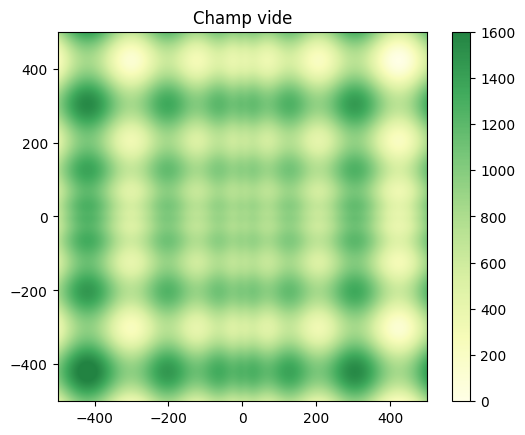

In [15]:
# Field image
path = pathlib.Path("figures")
path.mkdir(exist_ok=True)

fig = plot_bees(Z, title="Champ vide")
fig.savefig(path / "0_empty_field.png", dpi=300, transparent=True, bbox_inches="tight")

In [16]:
# rng = np.random.default_rng(456789123)
rng = np.random.default_rng(5678901234)

num_sources = 10

sources = rng.uniform(-500, 500, size=(num_sources, 2))
failure = np.zeros(num_sources, dtype=int)
source_objective = compute_objective(sources)
best = np.argmax(source_objective)
best_source = sources[best]
best_objective = source_objective[best]
source_objective

array([ 790.30688654,  437.196449  ,  539.15211547,  524.08302117,
        996.39370209,  657.56419915, 1245.59669301,  582.70093094,
       1102.37944574,  867.43789173])

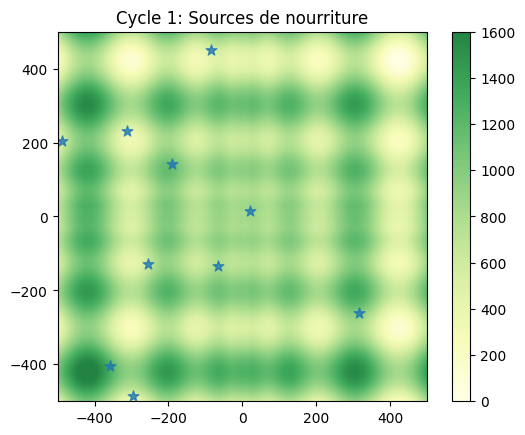

In [17]:
fig = plot_bees(Z, sources, title="Cycle 1: Sources de nourriture")
fig.savefig(path / "1_init_sources.png", dpi=300, transparent=True, bbox_inches="tight")

In [18]:
# Get positions of employed bees
employed, influences, coords = exploit_sources(sources, rng)

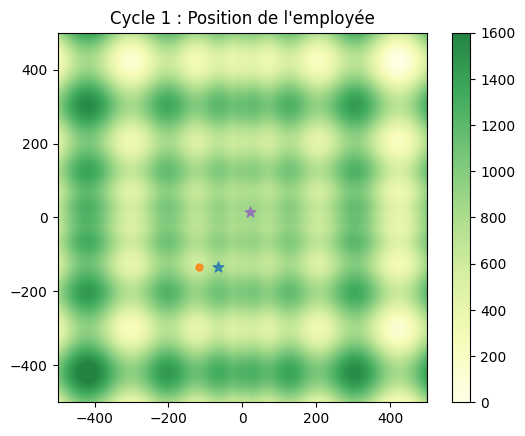

In [20]:
fig = plot_bees(
    Z,
    sources[0],
    employed[0],
    sources[influences][0],
    title="Cycle 1 : Position de l'employée",
    bee_types=[source_type, employee_type, influencing_type],
)
fig.savefig(path / "2a_employed.png", dpi=300, transparent=True, bbox_inches="tight")

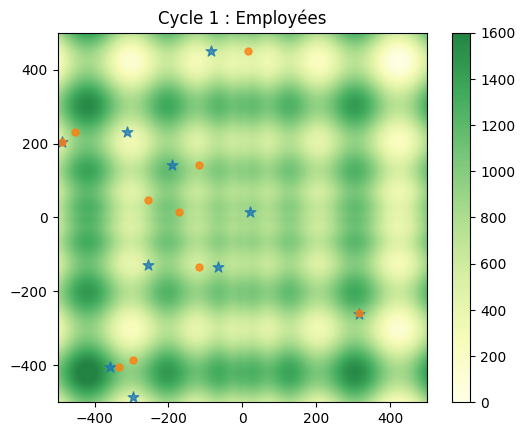

In [21]:
fig = plot_bees(Z, sources, employed, title="Cycle 1 : Employées")
fig.savefig(path / "2_employed.png", dpi=300, transparent=True, bbox_inches="tight")

In [22]:
# Check value of objective function for employees, update sources as necessary
employed_objective = compute_objective(employed)
employed_objective

array([ 610.92016117, 1014.99671306,  527.46210762,  805.25853442,
       1036.9342469 ,  756.68775653, 1040.63781485,  581.9814246 ,
        810.59358206,  933.14961329])

In [23]:
# Update each source
previous_sources = sources.copy()

sources, source_objective, failure = update_sources(
    sources, source_objective, failure, employed, employed_objective
)
failure

array([0, 1, 0, 1, 1, 1, 0, 0, 0, 1])

In [24]:
onlookers, onlooker_sources = assign_onlookers(sources, source_objective, rng)
onlooker_sources

array([7, 1, 9, 9, 1, 3, 3, 7, 0, 7])

In [25]:
onlookers, influences, coords = exploit_sources(onlookers, rng)
onlooker_objective = compute_objective(onlookers)

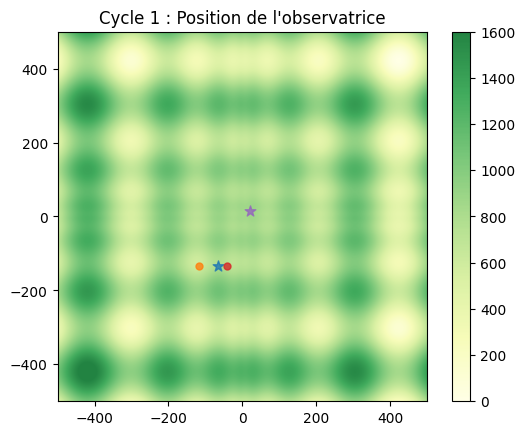

In [26]:
tmp_sources = previous_sources[0]
tmp_employed = employed[0]
tmp_onlookers = onlookers[onlooker_sources == 0]
tmp_influence = sources[influences[onlooker_sources == 0]]

fig = plot_bees(
    Z,
    tmp_sources,
    tmp_employed,
    tmp_onlookers,
    tmp_influence,
    title="Cycle 1 : Position de l'observatrice",
    bee_types=[source_type, employee_type, onlooker_type, influencing_type],
)
fig.savefig(path / "3a_onlookers.png", dpi=300, transparent=True, bbox_inches="tight")

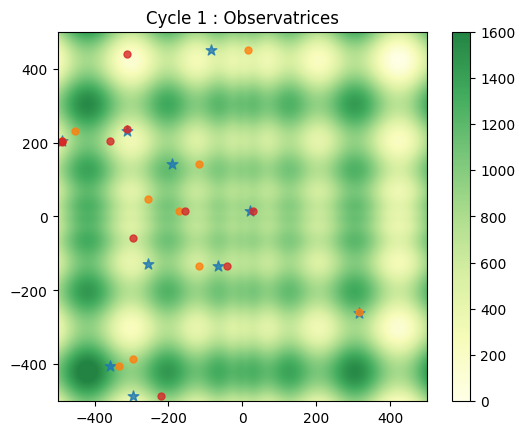

In [27]:
fig = plot_bees(
    Z, previous_sources, employed, onlookers, title="Cycle 1 : Observatrices"
)
fig.savefig(path / "3_onlookers.png", dpi=300, transparent=True, bbox_inches="tight")

In [28]:
# Update sources
sources, source_objective, failure = update_sources(
    sources, source_objective, failure, onlookers, onlooker_objective
)
failure

array([0, 0, 1, 2, 0, 0, 0, 1, 0, 0])

In [29]:
sources, source_objective, failure, scout = abandon_sources(
    sources, source_objective, failure, 2, rng
)
scout

3

In [30]:
failure

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0])

In [31]:
non_scout = np.arange(num_sources)[np.arange(num_sources) != scout]
non_scout

array([0, 1, 2, 4, 5, 6, 7, 8, 9])

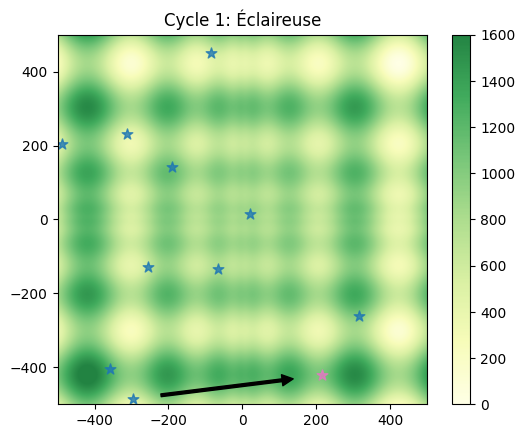

In [33]:
fig = plot_bees(
    Z,
    previous_sources,
    sources[scout],
    title="Cycle 1: Éclaireuse",
    bee_types=[source_type, scout_type],
)

ax = fig.axes[0]
ax.annotate(
    "",
    sources[scout],
    previous_sources[scout],
    arrowprops=dict(facecolor="black", shrink=0.15, width=2, headwidth=8, headlength=8),
)
fig.savefig(path / "4_scout.png", dpi=300, transparent=True, bbox_inches="tight")

## 3 - Algorithme complet

In [ ]:
def abc(field, num_sources, max_failures, cycles, rng=None):
    if rng is None:
        rng = np.random.default_rng(rng)

    # Initialisation
    sources = rng.uniform(-500, 500, size=(num_sources, 2))
    source_failure = np.zeros(num_sources)
    source_objective = compute_objective(sources)
    best = np.argmin(source_objective)
    best_objective = source_objective[best].copy()
    best_source = sources[best].copy()
    scout = None

    print(f"Initialisation - Meilleure source: {best_objective}")

    for i in range(cycles):
        # Assign employed bees
        employed, influences, coords = exploit_sources(sources, rng)
        employed_objective = compute_objective(employed)

        # Update sources
        previous_sources = sources.copy()
        sources, source_objective, source_failure = update_sources(
            sources, source_objective, source_failure, employed, employed_objective
        )

        # Assign onlookers
        onlookers, onlooker_sources = assign_onlookers(sources, source_objective, rng)
        onlookers, influences, coords = exploit_sources(onlookers, rng)
        onlooker_objective = compute_objective(onlookers)

        # Update sources
        sources, source_objective, source_failure = update_sources(
            sources,
            source_objective,
            source_failure,
            onlookers,
            onlooker_objective,
            onlooker_sources,
        )

        # Print best objective
        cycle_best = np.argmin(source_objective)

        if source_objective[cycle_best] < best_objective:
            best = cycle_best
            best_objective = source_objective[best]
            best_source = sources[best].copy()

        print(f"Cycle {i+1} - Meilleure source: {best_objective}")

        # Show bees
        if scout is None:
            fig = plot_bees(
                field,
                best_source,
                previous_sources,
                employed,
                onlookers,
                title=f"Cycle {i+1} - Meilleure source: {best_objective:0.2f}",
                bee_types=[best_type, source_type, employee_type, onlooker_type]
            )
        else:
            non_scout = np.arange(num_sources)[np.arange(num_sources) != scout]
            fig = plot_bees(
                field,
                best_source,
                previous_sources[non_scout],
                previous_sources[scout],
                employed,
                onlookers,
                title=f"Cycle {i+1} - Meilleure source: {best_objective:0.2f}",
                bee_types=[best_type, source_type, scout_type, employee_type, onlooker_type]
            )

        # Check for scout
        sources, source_objective, source_failure, scout = abandon_sources(
            sources, source_objective, source_failure, max_failures, rng
        )

        # Print best objective
        cycle_best_objective = source_objective.min()

        if cycle_best_objective < best_objective:
            best_objective = cycle_best_objective
            best_source = sources[np.argmin(source_objective)].copy()

        
        # print(source_failure)

        fig.savefig(path / f"cycle_{i+1}.png", dpi=300, bbox_inches="tight")
        plt.close(fig)

In [ ]:
# Algorithme complet
plt.close("all")
path = pathlib.Path("algorithme")
path.mkdir(exist_ok=True)

rng = np.random.default_rng(5678901234)

#abc(Z, 25, 50, 100, rng)
abc(Z, 10, 20, 60, rng)

Initialisation - Meilleure source: 437.196448997416
Cycle 1 - Meilleure source: 172.41903882727684
Cycle 2 - Meilleure source: 161.19903910863206
Cycle 3 - Meilleure source: 161.19903910863206
Cycle 4 - Meilleure source: 161.19903910863206
Cycle 5 - Meilleure source: 161.19903910863206
Cycle 6 - Meilleure source: 161.19903910863206
Cycle 7 - Meilleure source: 161.19903910863206
Cycle 8 - Meilleure source: 161.19903910863206
Cycle 9 - Meilleure source: 161.19903910863206
Cycle 10 - Meilleure source: 161.19903910863206
Cycle 11 - Meilleure source: 161.19903910863206
Cycle 12 - Meilleure source: 119.76341594094015
Cycle 13 - Meilleure source: 111.15435525439852
Cycle 14 - Meilleure source: 111.15435525439852
Cycle 15 - Meilleure source: 111.15435525439852
Cycle 16 - Meilleure source: 111.15435525439852
Cycle 17 - Meilleure source: 111.15435525439852
Cycle 18 - Meilleure source: 111.15435525439852
Cycle 19 - Meilleure source: 111.15435525439852
Cycle 20 - Meilleure source: 111.154355254398